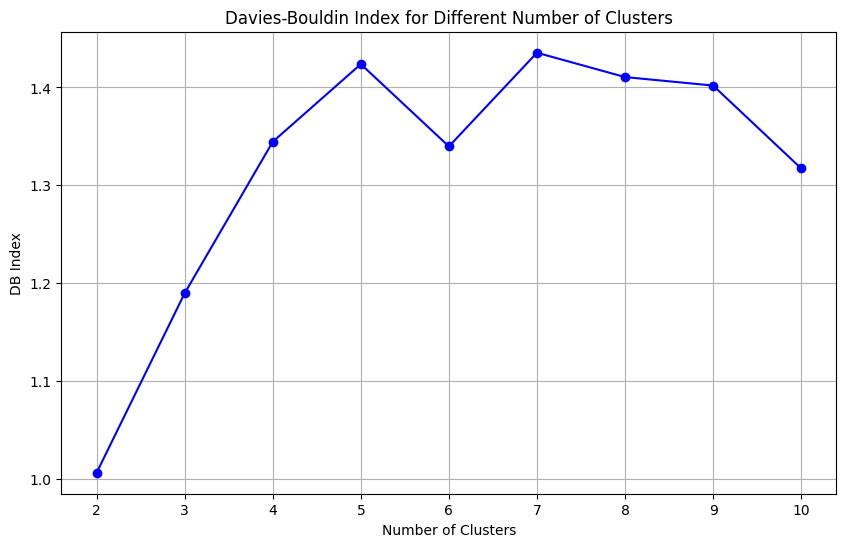

Optimal number of clusters based on DB Index: 2


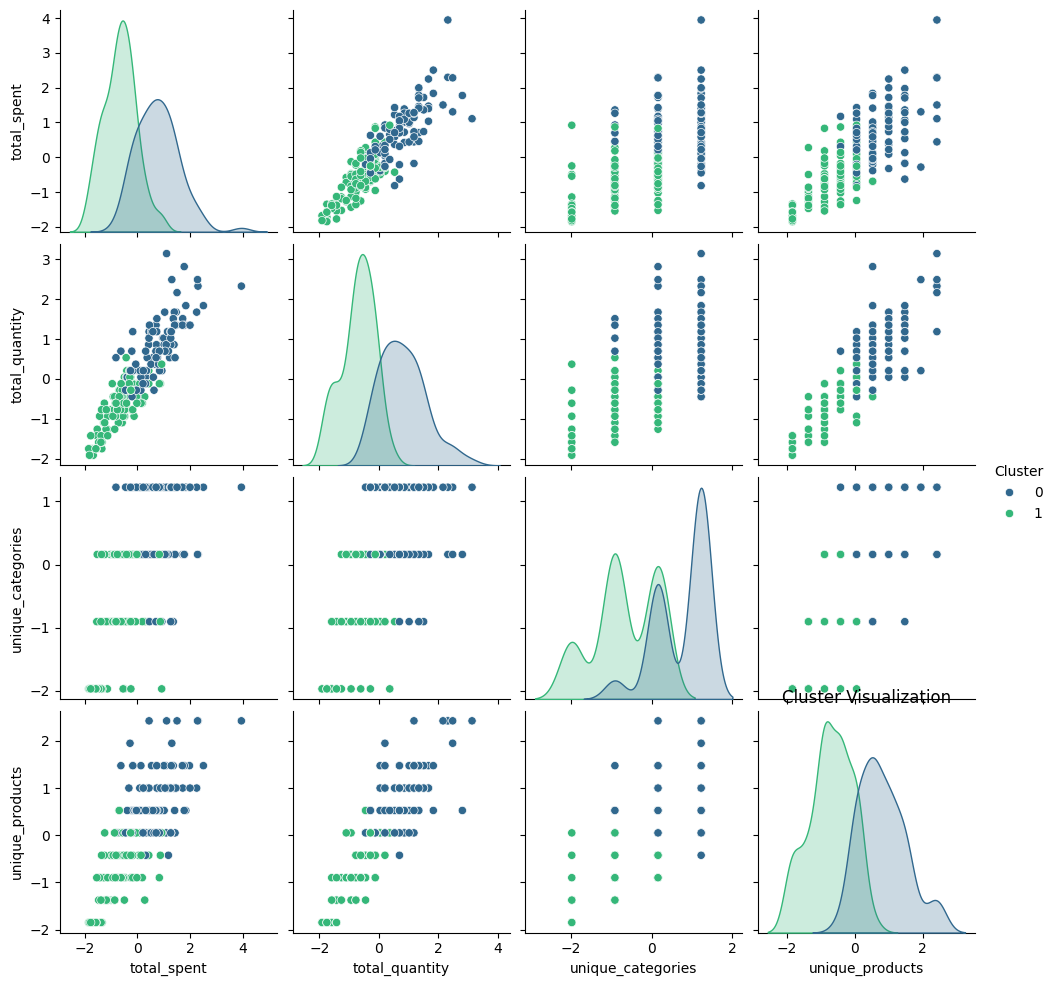

Clustering completed. Results saved to 'Clustering_Results.csv'.


In [7]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge data to create a comprehensive dataset
transactions = transactions.merge(products, on='ProductID')
transactions = transactions.merge(customers, on='CustomerID')

# Feature engineering: Aggregate transaction data by customer
customer_features = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    unique_categories=('Category', lambda x: x.nunique()),
    unique_products=('ProductID', 'nunique')
).reset_index()

# Add region as a categorical feature
customer_features = customer_features.merge(customers[['CustomerID', 'Region']], on='CustomerID')
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Normalize numerical features
scaler = StandardScaler()
numeric_features = ['total_spent', 'total_quantity', 'unique_categories', 'unique_products']
customer_features[numeric_features] = scaler.fit_transform(customer_features[numeric_features])

# Prepare feature matrix for clustering
feature_matrix = customer_features.drop(columns=['CustomerID']).values

# Perform K-Means clustering
optimal_clusters = None
db_scores = []

# Find the optimal number of clusters using the Davies-Bouldin Index
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(feature_matrix)
    db_index = davies_bouldin_score(feature_matrix, labels)
    db_scores.append(db_index)

# Plot DB Index to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_scores, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

# Choose the number of clusters with the lowest DB Index
optimal_clusters = db_scores.index(min(db_scores)) + 2
print(f"Optimal number of clusters based on DB Index: {optimal_clusters}")

# Final K-Means clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(feature_matrix)

# Visualize clusters using pairplot
sns.pairplot(customer_features, vars=numeric_features, hue='Cluster', palette='viridis')
plt.title('Cluster Visualization')
plt.show()

# Save clustering results
customer_features[['CustomerID', 'Cluster']].to_csv('Clustering_Results.csv', index=False)

print("Clustering completed. Results saved to 'Clustering_Results.csv'.")

Lookalike Model completed. Results saved to 'Lookalike.csv'.
